# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np
# show all columns
pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

from sklearn.preprocessing import RobustScaler
import tensorflow as tf

In [2]:
# import function files and environment variables
import utils

# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [45]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [5]:
# Read in the raw data
# raw_df_2001 = pd.read_sas(utils.read_cloud_data(bucket, '2001.sas7bdat'), format='sas7bdat') 
# raw_df_2002 = pd.read_csv(utils.read_cloud_data(bucket, '2002.tab'), sep='\t', lineterminator='\n')
# raw_df_2003 = pd.read_sas(utils.read_cloud_data(bucket, '2003.sas7bdat'), format='sas7bdat') 

# df_2001 = utils.make_readable(raw_df_2001, variable_values_df)
# df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)
# df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)

In [6]:
# Read in the raw data
raw_df_2016 = pd.read_sas(utils.read_cloud_data(bucket, '2016.sas7bdat'), format='sas7bdat') 
raw_df_2017 = pd.read_sas(utils.read_cloud_data(bucket, '2017.sas7bdat'), format='sas7bdat')
raw_df_2018 = pd.read_sas(utils.read_cloud_data(bucket, '2018.sas7bdat'), format='sas7bdat') 

In [7]:
# Read in the raw data
raw_df_2019 = pd.read_sas(utils.read_cloud_data(bucket, '2019.sas7bdat'), format='sas7bdat') 
raw_df_2020 = pd.read_sas(utils.read_cloud_data(bucket, '2020.sas7bdat'), format='sas7bdat')
raw_df_2021 = pd.read_sas(utils.read_cloud_data(bucket, '2021.sas7bdat'), format='sas7bdat') 

In [46]:
df_2016 = utils.make_readable(raw_df_2016.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2017 = utils.make_readable(raw_df_2017.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2018 = utils.make_readable(raw_df_2018.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2019 = utils.make_readable(raw_df_2019.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2020 = utils.make_readable(raw_df_2020.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2021 = utils.make_readable(raw_df_2021.rename({'FY':'DataYear'}, axis=1), variable_values_df)

# Filter and Clean Data

In [47]:
# Bring all data together
all_records = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020, df_2021], axis=0)
# all_records = df_2001.reset_index(drop=True) # temporarily doing 2001 only so that the code runs faster
print(f"All Records: {all_records.shape}")

All Records: (3974699, 59)


In [52]:
# keep only the cases where the child has exited foster care
records_df = all_records[all_records['EXITED'] == 1]
print(f"Filting for Exited Only: {records_df.shape}")

# keep only kids who are 18 years old or older by 2021 so we know they never re-entered foster care
records_df = records_df[records_df['age2021'] >= 18]
print(f"Filting for 18 YO and Older: {records_df.shape}")
records_df.drop(columns=['age2021'], inplace=True)

# keep only records where child is under 21 years old (when foster care ends)
records_df = records_df[records_df['AGEATEND'] <= 21]
print(f"Filting for Under 22 YO: {records_df.shape}")

Filting for Exited Only: (1440340, 59)
Filting for 18 YO and Older: (1440313, 59)
Filting for Under 22 YO: (1440247, 59)


In [54]:
num_yrs_df = records_df[['RECNUMBR', 'DATAYEAR']].reset_index().groupby(['RECNUMBR', 'DATAYEAR']).count().reset_index()
num_yrs_df.columns = ['RECNUMBR', 'DATAYEAR', 'COUNT']
total_yrs = num_yrs_df.groupby('RECNUMBR')['COUNT'].count().reset_index().rename({'COUNT':'TOTAL_YRS'}, axis=1)
num_yrs_df = num_yrs_df.pivot(index='RECNUMBR', columns='DATAYEAR', values='COUNT').reset_index()
num_yrs_df = num_yrs_df.merge(total_yrs, on='RECNUMBR', how='left').sort_values('TOTAL_YRS', ascending=False).reset_index(drop=True)

In [55]:
reentry_check_df = utils.mark_reentries(num_yrs_df.fillna(0), 2016, 2021)

In [56]:
records_df = records_df.merge(reentry_check_df, on='RECNUMBR')

In [57]:
records_df.drop_duplicates(subset=['RECNUMBR'], keep= 'last', inplace=True) # removing duplicate records, keeping the last one - the most recent
print(f"Removing Duplicates: {records_df.shape}") 

Removing Duplicates: (1372274, 66)


In [58]:
records_df = utils.remove_nan_values(records_df)

Total Null Values: 0
Total Records: 1372274
Total Columns: 66


In [59]:
# Create Binary label for if they have reunified
records_df['reunified'] = 0
records_df.loc[(records_df['EXITED'] == 1) & (records_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1
records_df[(records_df['Reentry'] == True) & (records_df['reunified'] == 1) & (records_df['2021'] == 0)]['reunified'] = 0 # these are the unsuccessful reunifications - they reentered foster care before 2021
print(f"Unsuccuessful reunifications: {len(records_df[(records_df['Reentry'] == True) & (records_df['reunified'] == 1) & (records_df['2021'] == 0)])}")
records_df = records_df.drop(columns=['EXITED', 'INATEND']) # drop these, all are 1 now

Unsuccuessful reunifications: 14646


/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_99985/3803088158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records_df[(records_df['Reentry'] == True) & (records_df['reunified'] == 1) & (records_df['2021'] == 0)]['reunified'] = 0 # these are the unsuccessful reunifications - they reentered foster care before 2021


In [60]:
records_df.head()

,DATAYEAR,RECNUMBR,MR,VISHEAR,PHYDIS,EMOTDIST,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMNTPAY,SETTINGLOS,PREVIOUSLOS,LIFELOS,AGEATLATREM,AGEATEND,INATSTART,SERVED,ISWAITING,ISTPR,AGEDOUT,State,FIPSCode,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caseGoal,caretakerFamilyStructure,fosterFamilyStructure,dischargeReason,raceEthnicity,everAdopted,diagnosedDisability,2016,2017,2018,2019,2020,2021,TOTAL_YRS,Reentry,reunified
0,2016,b'000000006031',0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,488.0,487.0,0.0,727.0,10.0,12.0,1.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,"Foster home, non-relative",Yes,Live with other relative(s),Single female,DNG,Living with other relative(s),"Non-Hispanic (NH), White","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False,0
1,2016,b'000000009831',0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,66.0,567.0,637.0,17.0,17.0,0.0,1.0,0.0,0.0,1.0,Alabama,"Jefferson, AL",Female,Not applicable,Court ordered,Group home,No,"Reunify with parent, principal caretaker",Married couple,Not applicable,Emancipation,"Non-Hispanic (NH), White","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False,0
2,2016,b'000000014871',0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,501.0,85.0,0.0,2417.0,13.0,20.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Female,Not applicable,Court ordered,Runaway,No,Emancipation,Married couple,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False,0
4,2016,b'000000026281',0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,904.0,0.0,1995.0,15.0,21.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,Supervised independent living,No,Emancipation,Single female,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False,0
5,2016,b'000000032714',0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,690.0,959.0,13.0,14.0,0.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,Trial home visit,No,"Reunify with parent, principal caretaker",Single female,Not applicable,"Reunified with parent, primary caretaker","Non-Hispanic (NH), White","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False,1


# Visualizing the data

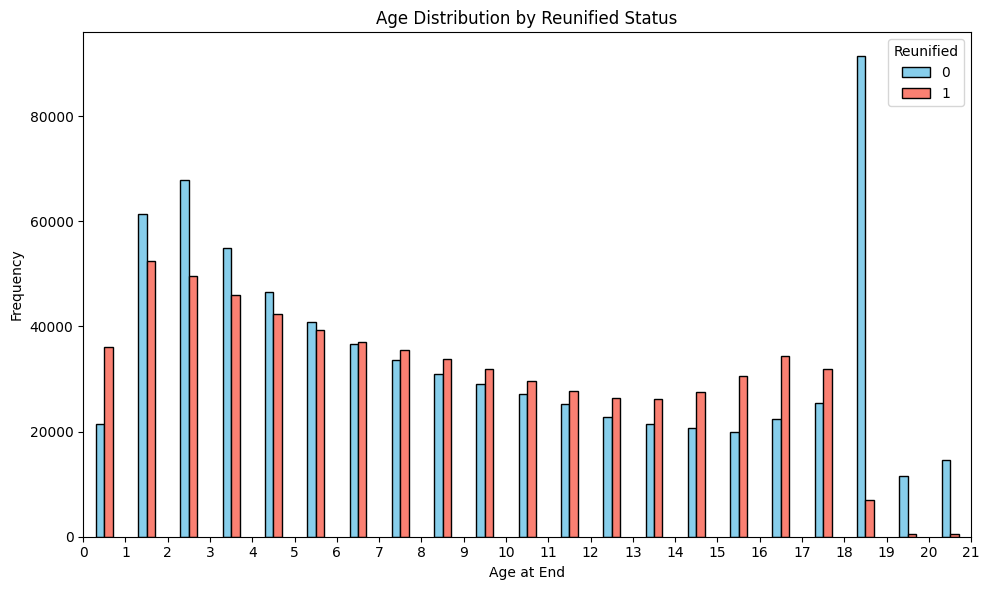

In [61]:
# Filter the DataFrame for each category in 'reunified'
group1 = records_df[records_df['reunified'] == records_df['reunified'].unique()[0]]['AGEATEND']
group2 = records_df[records_df['reunified'] == records_df['reunified'].unique()[1]]['AGEATEND']

plt.figure(figsize=(10, 6))

# Set the positions of the bars
bins = np.histogram_bin_edges(records_df['AGEATEND'], bins=21)
width = (bins[1] - bins[0]) * 0.4

plt.hist([group1, group2], bins=bins, label=[str(records_df['reunified'].unique()[0]), str(records_df['reunified'].unique()[1])], 
         color=['skyblue', 'salmon'], edgecolor='black',  rwidth=width, align='mid', histtype='bar')

plt.legend(title='Reunified')
plt.xlabel('Age at End')
plt.ylabel('Frequency')
plt.title('Age Distribution by Reunified Status')

plt.xticks(bins.round(2))
plt.xlim([bins.min(), bins.max()])  
plt.tight_layout()
plt.show()


Text(0, 0.5, '% Reunified')

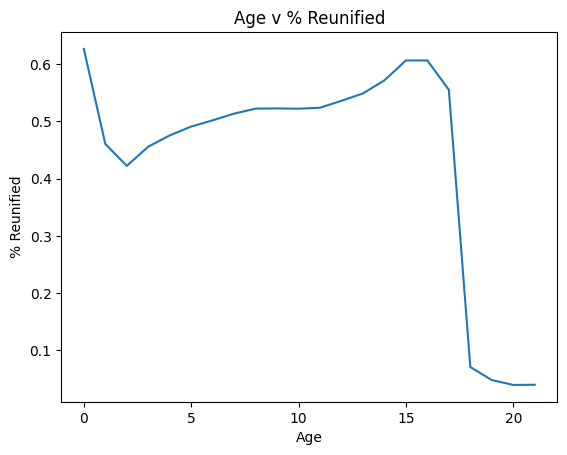

In [62]:
# plot age v % that reunified
age_reunified = records_df.groupby('AGEATEND')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

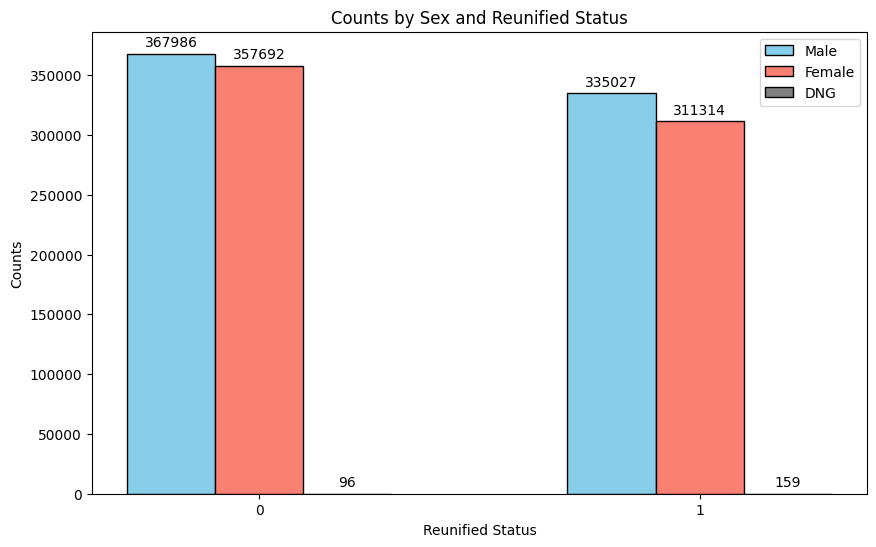

In [63]:
count_matrix = records_df.groupby(['reunified', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(count_matrix))
width = 0.2 # the width of the bars

# Plotting the bars
bars1 = ax.bar(ind - width, count_matrix['Male'], width, label='Male', color='skyblue', edgecolor='black')
bars2 = ax.bar(ind, count_matrix['Female'], width, label='Female', color='salmon', edgecolor='black')
bars3 = ax.bar(ind + width, count_matrix['DNG'], width, label='DNG', color='grey', edgecolor='black')

ax.set_xlabel('Reunified Status')
ax.set_ylabel('Counts')
ax.set_title('Counts by Sex and Reunified Status')
ax.set_xticks(ind)
ax.set_xticklabels(count_matrix.index)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
ax.bar_label(bars3, padding=3)

plt.show()


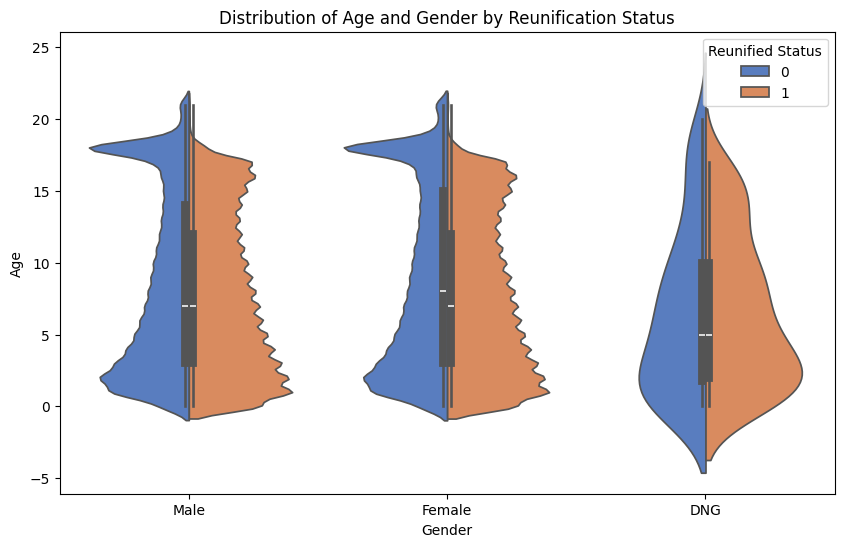

In [64]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sex", y="AGEATEND", hue="reunified", data=records_df, palette="muted", split=True)

plt.title('Distribution of Age and Gender by Reunification Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Reunified Status')

plt.show()

# Creating Train-Validation-Test Datasets
Split the data into three sections: training at 60%, validation at 20%, and testing at 20%

In [65]:
# Shuffle the data randomly to avoid any biases
records_df = records_df.sample(frac = 1, random_state=42)

# Drop columns that are indicators or not useful
data_df = records_df.drop(['DATAYEAR', 'RECNUMBR', 'caseGoal', 'dischargeReason', 'FIPSCode'], axis=1)
data_oh_df = pd.get_dummies(data_df, columns=['State', 'Sex', 'removalManner', 'currentPlacementSetting', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement']) # 'FIPSCode',

X = data_oh_df.drop('reunified', axis=1)  # Features
y = data_oh_df['reunified']  # Target variable

In [66]:
# Scale X but keep the feature names
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = pd.DataFrame(X)

In [67]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Val Set Shape: {X_val.shape}")
print(f"Test Set Shape: {X_test.shape}")

Training Set Shape: (823364, 154)
Val Set Shape: (274455, 154)
Test Set Shape: (274455, 154)


# Baseline Model

## Everyone Reunifies

In [68]:
# baseline from test data - if we just guess the majority class
print(f"Reunified: {y_train[y_train == 1].shape[0]}")
print(f"Not Reunified: {y_train[y_train == 0].shape[0]}")

baseline = y_train.value_counts()[0] / y_train.value_counts().sum()
print(f"\nBaseline (% Reunified): {round((y_train[y_train == 1].shape[0] / y_train.shape[0])*100, 2)}%")

Reunified: 388226
Not Reunified: 435138

Baseline (% Reunified): 47.15%


## Log Loss

In [69]:
# Calculate the baseline loss for the training dataset

def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.
  
  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """
  loss = -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
  return loss

# Use the log_loss function to evaluate our baseline on the train, validation, and test dataset using the average of reunified as our predicted probability.

train_loss = log_loss(y_train, baseline)
val_loss = log_loss(y_val, baseline)
test_loss = log_loss(y_test, baseline)

print("Log Loss for Baseline on Training Dataset:", train_loss)
print("Log Loss for Baseline on Validation Dataset:", val_loss)
print("Log Loss for Baseline on Test Dataset:", test_loss)

Log Loss for Baseline on Training Dataset: 0.69802273995104
Log Loss for Baseline on Validation Dataset: 0.6982196819927471
Log Loss for Baseline on Test Dataset: 0.6980517618110655


# Random Forest

In [70]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [71]:
# Predictions
y_pred = rf.predict(X_train)

# Accuracy
print('Training Accuracy : ', 
      metrics.accuracy_score(y_train,
                             rf.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf.predict(X_val))*100)

# Classification report
print('Classification Report, Validation:\n', classification_report(y_val, rf.predict(X_val)))

Training Accuracy :  99.99611350508401
Validation Accuracy :  90.83674919385692
Classification Report, Validation:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91    145520
           1       0.88      0.93      0.90    128935

    accuracy                           0.91    274455
   macro avg       0.91      0.91      0.91    274455
weighted avg       0.91      0.91      0.91    274455



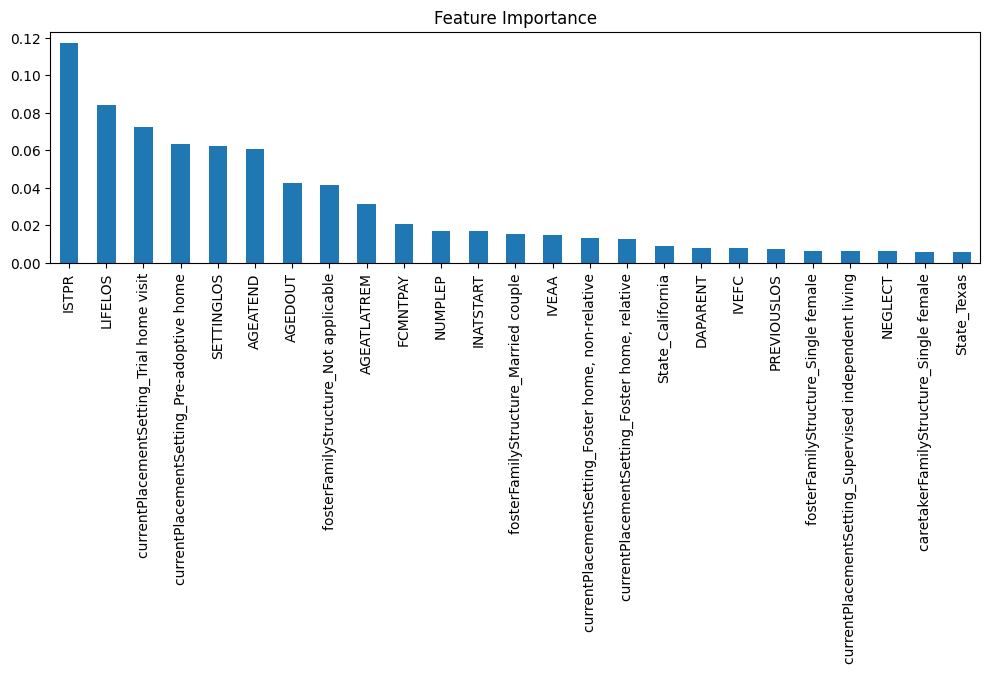

In [72]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:25].plot(kind='bar', figsize=(12, 3))
plt.title('Feature Importance')
plt.show()

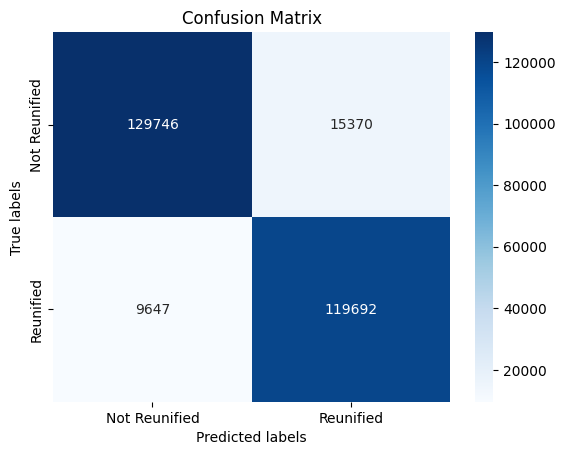

In [73]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# max_depths = np.arange(1, 20, 2)

# train_results = []
# val_results = []

# for i in max_depths:
#     dt = RandomForestClassifier(max_depth=i)
#     dt.fit(X_train, y_train)    

#     # Calculate and display accuracy
#     accuracy = metrics.accuracy_score(y_train, dt.predict(X_train))
#     #append results of accuracy
#     print(i, accuracy)
#     train_results.append(accuracy)
    
#     #now again for test data
#     accuracy = metrics.accuracy_score(y_val, dt.predict(X_val))
#     #append results of accuracy
#     print(i, accuracy)
#     val_results.append(accuracy)
    
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
# line2, = plt.plot(max_depths, val_results, 'r', label= 'Validation accuracy')

# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('Accuracy score')
# plt.xlabel('Tree depth')

In [29]:
# n_estimators = np.arange(1, 12, 2)

# train_results = []
# val_results = []

# for i in n_estimators:
#     dt = RandomForestClassifier(max_depth=15, n_estimators=i)
#     dt.fit(X_train, y_train)    

#     # Calculate and display accuracy
#     accuracy = metrics.accuracy_score(y_train, dt.predict(X_train))
#     #append results of accuracy
#     print(i, accuracy)
#     train_results.append(accuracy)
    
#     #now again for test data
#     accuracy = metrics.accuracy_score(y_val, dt.predict(X_val))
#     #append results of accuracy
#     print(i, accuracy)
#     val_results.append(accuracy)
    
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(n_estimators, train_results, 'b', label='Train accuracy')
# line2, = plt.plot(n_estimators, val_results, 'r', label= 'Validation accuracy')

# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('Accuracy score')
# plt.xlabel('Estimators')

## Update Model based on new info

In [74]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=6, max_depth=15, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=6, random_state=42)

In [75]:
# Predictions
y_pred = rf.predict(X_train)

# Accuracy
print('Training Accuracy : ', 
      metrics.accuracy_score(y_train,
                             rf.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf.predict(X_val))*100)

# Classification report
print('Classification Report, Validation:\n', classification_report(y_val, rf.predict(X_val)))

Training Accuracy :  87.34933759552275
Validation Accuracy :  86.96471188355103
Classification Report, Validation:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87    145520
           1       0.82      0.92      0.87    128935

    accuracy                           0.87    274455
   macro avg       0.87      0.87      0.87    274455
weighted avg       0.87      0.87      0.87    274455



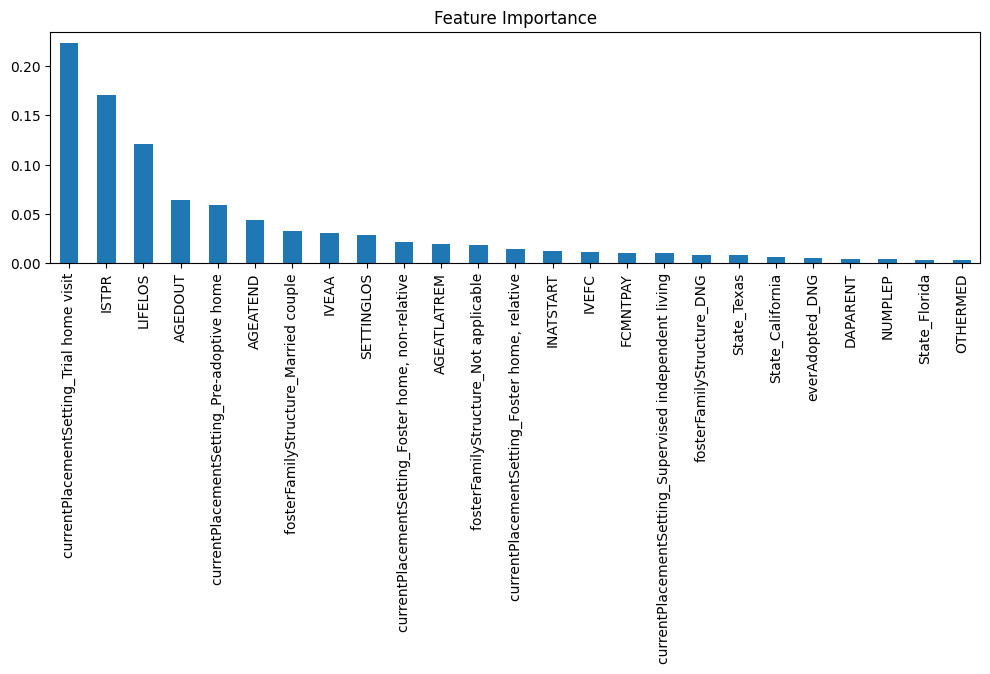

In [76]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:25].plot(kind='bar', figsize=(12, 3))
plt.title('Feature Importance')
plt.show()

In [33]:
# from sklearn.tree import plot_tree

# # Pick a single tree from the forest
# single_tree = rf.estimators_[0]

# plt.figure(figsize=(60,30))
# plot_tree(single_tree, filled=True, feature_names=X.columns, max_depth=4, proportion=True)
# plt.show()

# XG Boost Model

In [81]:
# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model training parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [82]:
# Making predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8991960192246643
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     71791
           1       0.87      0.92      0.90     63660

    accuracy                           0.90    135451
   macro avg       0.90      0.90      0.90    135451
weighted avg       0.90      0.90      0.90    135451



In [83]:
# from sklearn.model_selection import GridSearchCV

# xgb_model = xgb.XGBClassifier()
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# KNN Model

In [102]:
# KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8554311153110719
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     72177
           1       0.82      0.88      0.85     63274

    accuracy                           0.86    135451
   macro avg       0.86      0.86      0.86    135451
weighted avg       0.86      0.86      0.86    135451



# CNN Model

In [79]:
data_df.shape

(1372274, 60)

In [80]:
def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Numberical Inputs
    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
    total_yrs = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='TOTAL_YRS')
    
    # Binned Numerical Inputs
    total_rem = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='TOTALREM')
    total_rem_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    total_rem_binned = tf.keras.layers.Discretization(bin_boundaries=total_rem_bins)(total_rem)
    total_rem_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(total_rem_bins)+1),
        output_mode='one_hot')(total_rem_binned)
    
    num_place = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NUMPLEP')
    num_place_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    num_place_binned = tf.keras.layers.Discretization(bin_boundaries=num_place_bins)(num_place)
    num_place_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(num_place_bins)+1),
        output_mode='one_hot')(num_place_binned)
    
    fcmntPay = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='FCMntPay')
    fcmntPay_bins = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    fcmntPay_binned = tf.keras.layers.Discretization(bin_boundaries=fcmntPay_bins)(fcmntPay)
    fcmntPay_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(fcmntPay_bins)+1),
        output_mode='one_hot')(fcmntPay_binned)
    
    settingLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SettingLOS')
    settingLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    settingLOS_binned = tf.keras.layers.Discretization(bin_boundaries=settingLOS_bins)(settingLOS)
    settingLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(settingLOS_bins)+1),
        output_mode='one_hot')(settingLOS_binned)
    
    previousLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PreviousLOS')
    previousLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    previousLOS_binned = tf.keras.layers.Discretization(bin_boundaries=previousLOS_bins)(previousLOS)
    previousLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(previousLOS_bins)+1),
        output_mode='one_hot')(previousLOS_binned)
    
    lifeLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='LifeLOS')
    lifeLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    lifeLOS_binned = tf.keras.layers.Discretization(bin_boundaries=lifeLOS_bins)(lifeLOS)
    lifeLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(lifeLOS_bins)+1),
        output_mode='one_hot')(lifeLOS_binned)
    
    ageAtLatRem = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AgeAtLatRem')
    ageAtLatRem_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    ageAtLatRem_binned = tf.keras.layers.Discretization(bin_boundaries=ageAtLatRem_bins)(ageAtLatRem)
    ageAtLatRem_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(ageAtLatRem_bins)+1),
        output_mode='one_hot')(ageAtLatRem_binned)
    
    # Categorical Inputs
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
    sex_id = tf.keras.layers.StringLookup(
        vocabulary=['Male', 'Female', 'DNG'], output_mode='one_hot')(sex)
    
    state = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='State')
    state_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['State'].unique(), output_mode='one_hot')(state)
    
    removal_manner = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='removalManner')
    removal_manner_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['removalManner'].unique(), output_mode='one_hot')(removal_manner)
    
    current_placement_setting = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='currentPlacementSetting')
    current_placement_setting_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['currentPlacementSetting'].unique(), output_mode='one_hot')(current_placement_setting)
    
    out_of_state_placement = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='OutOfStatePlacement')
    out_of_state_placement_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['OutOfStatePlacement'].unique(), output_mode='one_hot')(out_of_state_placement)
    
    caretaker_family_structure = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='caretakerFamilyStructure')
    caretaker_family_structure_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['caretakerFamilyStructure'].unique(), output_mode='one_hot')(caretaker_family_structure)
    
    foster_family_structure = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='fosterFamilyStructure')
    foster_family_structure_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['fosterFamilyStructure'].unique(), output_mode='one_hot')(foster_family_structure)
    
    ever_adopted = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='everAdopted')
    ever_adopted_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['everAdopted'].unique(), output_mode='one_hot')(ever_adopted)
    
    diagnosed_disability = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='diagnosedDisability')
    diagnosed_disability_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['diagnosedDisability'].unique(), output_mode='one_hot')(diagnosed_disability)
    
    raceEthnicity = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='raceEthnicity')
    raceEthnicity_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['diagnosedDisability'].unique(), output_mode='one_hot')(raceEthnicity)
    
    # Binary Inputs
    mr = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='MR')
    vishear = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='VISHEAR')
    phydis = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PHYDIS')
    emotdist = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='EMOTDIST')
    othermed = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='OTHERMED')
    phyabuse = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PHYABUSE')
    sexabuse = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SEXABUSE')
    neglect = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NEGLECT')
    aaparent = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AAPARENT')
    daparent = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DAPARENT')
    aachild = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AACHILD')
    dachild = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DACHILD')
    childis = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='CHILDIS')
    chbehprb = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='CHBEHPRB')
    prtsdied = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PRTSDIED')
    prtsjail = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PRTSJAIL')
    nocope = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NOCOPE')
    abandmnt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='ABANDMNT')
    relinquish = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='RELINQSH')
    housing = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='HOUSING')
    ivefc = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVEFC')
    iveaa = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVEAA')
    ivaafdc = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVAAFDC')
    ivdchsup = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVDCHSUP')
    xixmedcd = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='XIXMEDCD')
    ssiother = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SSIOTHER')
    noa = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NOA')
    istpr = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IsTPR')
    served = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Served')
    yr_2016 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='2016')
    yr_2017 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='2017')
    yr_2018 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='2018')
    yr_2019 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='2019')
    yr_2020 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='2020')
    yr_2021 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='2021')

    
    features = tf.keras.layers.Concatenate()([sex_id, 
                                              mr, vishear, phydis, othermed, phyabuse, sexabuse, neglect,  emotdist, 
                                              aaparent, daparent, aachild, dachild, childis, chbehprb, prtsdied, prtsjail, nocope, abandmnt, relinquish, housing, 
                                              ivefc, iveaa, ivaafdc, ivdchsup, xixmedcd, ssiother, noa,
                                              istpr, served, state_id, removal_manner_id, current_placement_setting_id, out_of_state_placement_id, caretaker_family_structure_id, foster_family_structure_id, ever_adopted_id, diagnosed_disability_id, raceEthnicity_id,
                                              # numerical columns
                                              age, total_yrs, # total_rem, num_place, fcmntPay, settingLOS, previousLOS, lifeLOS, ageAtLatRem
                                              # age_id, 
                                              total_rem_id, num_place_id,fcmntPay_id, settingLOS_id, previousLOS_id, lifeLOS_id, ageAtLatRem_id, yr_2016, yr_2017, yr_2018, yr_2019, yr_2020, yr_2021
                                              ])

    normalized_features = tf.keras.layers.BatchNormalization()(features)
    
    dense = tf.keras.layers.Dense(units=64, activation='relu', name='hidden1')(normalized_features)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    
    dense = tf.keras.layers.Dense(units=32, activation='relu', name='hidden2')(dense)
    dense = tf.keras.layers.Dropout(0.3)(dense)

    reunified = tf.keras.layers.Dense(units=1, activation='sigmoid', name='reunified')(dense)

    model = tf.keras.Model(inputs=[sex, 
                                   mr, vishear, phydis,  othermed, phyabuse, sexabuse, neglect, emotdist,
                                   aaparent, daparent, aachild, dachild, childis, chbehprb, prtsdied, prtsjail, nocope, abandmnt, relinquish, housing,
                                   ivefc, iveaa, ivaafdc, ivdchsup, xixmedcd, ssiother, noa,
                                   istpr, served, state, removal_manner, current_placement_setting, out_of_state_placement, caretaker_family_structure, foster_family_structure, ever_adopted, diagnosed_disability, raceEthnicity,
                                   # numerical columns
                                    age, total_yrs, total_rem, num_place, fcmntPay, settingLOS, previousLOS, lifeLOS, ageAtLatRem, 
                                    yr_2016, yr_2017, yr_2018, yr_2019, yr_2020, yr_2021
                                   ], 
                           outputs=reunified, 
                           name='Foster')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [81]:
model = build_model()
inputs = {
        'Age': data_df['AGEATEND'],
        'TOTAL_YRS': data_df['TOTAL_YRS'], 
        'Sex': data_df['Sex'],
        'MR': data_df['MR'],
        'TOTALREM': data_df['TOTALREM'],
        'NUMPLEP': data_df['NUMPLEP'],
        'VISHEAR': data_df['VISHEAR'],
        'PHYDIS': data_df['PHYDIS'],
        'EMOTDIST': data_df['EMOTDIST'],
        'OTHERMED': data_df['OTHERMED'],
        'PHYABUSE': data_df['PHYABUSE'],
        'SEXABUSE': data_df['SEXABUSE'],
        'NEGLECT': data_df['NEGLECT'],
        'AAPARENT': data_df['AAPARENT'],
        'DAPARENT': data_df['DAPARENT'],
        'AACHILD': data_df['AACHILD'],
        'DACHILD': data_df['DACHILD'],
        'CHILDIS': data_df['CHILDIS'],
        'CHBEHPRB': data_df['CHBEHPRB'],
        'PRTSDIED': data_df['PRTSDIED'],
        'PRTSJAIL': data_df['PRTSJAIL'],
        'NOCOPE': data_df['NOCOPE'],
        'ABANDMNT': data_df['ABANDMNT'],
        'RELINQSH': data_df['RELINQSH'],
        'HOUSING': data_df['HOUSING'],
        'IVEFC': data_df['IVEFC'],
        'IVEAA': data_df['IVEAA'],
        'IVAAFDC': data_df['IVAAFDC'],
        'IVDCHSUP': data_df['IVDCHSUP'],
        'XIXMEDCD': data_df['XIXMEDCD'],
        'SSIOTHER': data_df['SSIOTHER'],
        'NOA': data_df['NOA'],
        'FCMntPay': data_df['FCMNTPAY'],
        'SettingLOS': data_df['SETTINGLOS'],
        'PreviousLOS': data_df['PREVIOUSLOS'],
        'LifeLOS': data_df['LIFELOS'],
        'AgeAtLatRem': data_df['AGEATLATREM'],
        'IsTPR': data_df['ISTPR'],
        'Served': data_df['SERVED'],
        'State': data_df['State'],
        'removalManner': data_df['removalManner'],
        'currentPlacementSetting': data_df['currentPlacementSetting'],
        'caretakerFamilyStructure': data_df['caretakerFamilyStructure'],
        'fosterFamilyStructure': data_df['fosterFamilyStructure'],
        'OutOfStatePlacement': data_df['OutOfStatePlacement'],
        'everAdopted': data_df['everAdopted'],
        'diagnosedDisability': data_df['diagnosedDisability'],
        'raceEthnicity': data_df['raceEthnicity'],
        '2016': data_df['2016'],
        '2017': data_df['2017'],
        '2018': data_df['2018'],
        '2019': data_df['2019'],
        '2020': data_df['2020'],
        '2021': data_df['2021']
        }
history = model.fit(
    x = inputs,
    y = data_df['reunified'],
    validation_data=(
        inputs,
        data_df['reunified']),
    epochs=3,
    batch_size=32
)

Epoch 1/3
 1511/42884 ━━━━━━━━━━━━━━━━━━━━ 38:06 55ms/step - accuracy: 0.7748 - loss: 0.4415

21165/21165 ━━━━━━━━━━━━━━━━━━━━ 571s 27ms/step


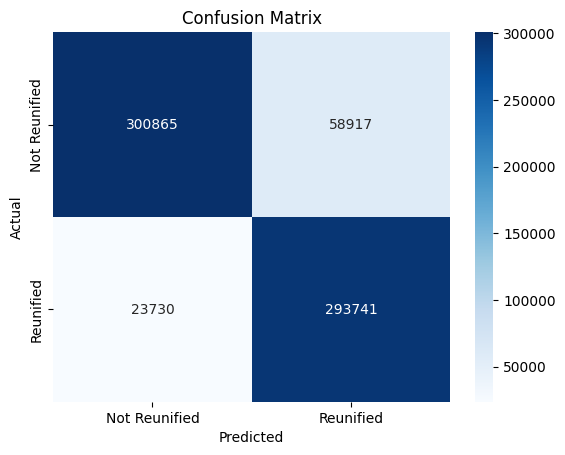

In [103]:
predictions_prob = model.predict(inputs)
predictions = (predictions_prob > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(data_df['reunified'], predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

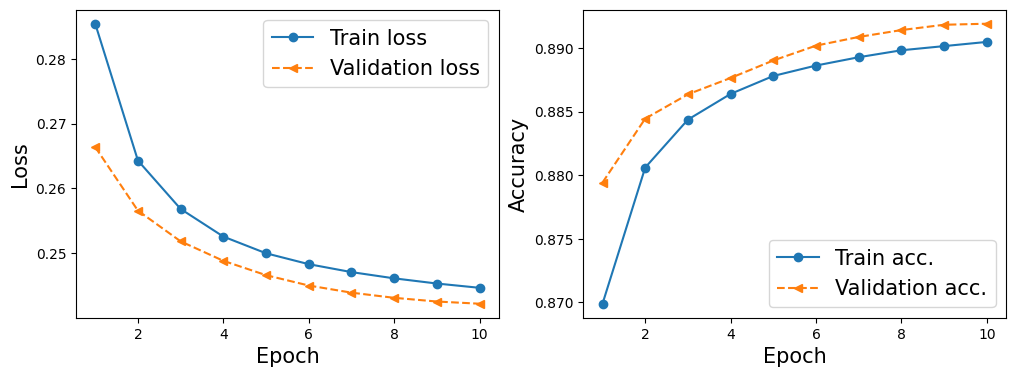

In [118]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
print("Accuracy - Age & Sex Only: 0.5622")
print("Accuracy - (Age, sex, All cols to Housing): 0.6351")
print("Accuracy - (Age, sex, All cols to Housing): 0.6624")
print("Accuracy - (Age, sex, All cols not race eth): 0.81")
print("Accuracy with binning: 0.8230")
print("Accuracy without binning: 0.7834")
print("Accuracy with binning except age: 0.8283")

print("Accuracy with new 2019-2021 dataset: 0.8864")

Accuracy - Age & Sex Only: 0.5622
Accuracy - (Age, sex, All cols to Housing): 0.6351
Accuracy - (Age, sex, All cols to Housing): 0.6624
Accuracy - (Age, sex, All cols not race eth): 0.81


# Bias Testing

In [43]:
# Predict for Random Forest Model
rf_y_pred = rf.predict(X_test)

# Convert predictions to a binary outcome
rf_y_pred_binary = (rf_y_pred > 0.5).astype(int)

# Ensure X_test is a DataFrame and create a new DataFrame from it
rf_test_df = pd.DataFrame(X_test).reset_index(drop=True)

# Reset the index of y_test if it's a Series to align with the DataFrame's index
# If y_test is an array, this step is not necessary
rf_test_df['Actual'] = y_test.reset_index(drop=True) if isinstance(y_test, pd.Series) else y_test

# Assign the binary predictions
# This should work as is if rf_y_pred_binary is an array, but if it's a Series, you need to reset the index
rf_test_df['Predicted'] = rf_y_pred_binary.reset_index(drop=True) if isinstance(rf_y_pred_binary, pd.Series) else rf_y_pred_binary

# Now rf_test_df should have the columns properly added


In [40]:
# # Predict for Random Forest Model
# rf_y_pred = rf.predict(X_test)

# # Convert predictions to a binary outcome
# rf_y_pred_binary = (rf_y_pred > 0.5).astype(int)

# # Add predictions to your test dataframe
# rf_test_df = pd.DataFrame(X_test, columns=X_test.columns)
# rf_test_df['Actual'] = y_test
# rf_test_df['Predicted'] = rf_y_pred_binary

In [90]:
# Predict for NN Model
nn_y_pred = model.predict(inputs)
# Convert predictions to a binary outcome
nn_y_pred_binary = (nn_y_pred > 0.5).astype(int)

# Add predictions to your test dataframe
nn_test_df = pd.DataFrame(inputs, columns=inputs.keys())
nn_test_df['Actual'] = data_df['reunified']
nn_test_df['Predicted'] = nn_y_pred_binary

21165/21165 ━━━━━━━━━━━━━━━━━━━━ 570s 27ms/step


### Sex - Random Forest

In [71]:
# Calculate accuracy for each group
rf_accuracy_female = rf_test_df[rf_test_df['Sex_Female'] == 1]['Actual'] == rf_test_df[rf_test_df['Sex_Female'] == 1]['Predicted']
rf_accuracy_male = rf_test_df[rf_test_df['Sex_Male'] == -1]['Actual'] == rf_test_df[rf_test_df['Sex_Male'] == -1]['Predicted']
rf_accuracy_dng = rf_test_df[rf_test_df['Sex_DNG'] == 1]['Actual'] == rf_test_df[rf_test_df['Sex_DNG'] == 1]['Predicted']

print(f"Accuracy for Male: {rf_accuracy_male.mean()}")
print(f"Accuracy for Female: {rf_accuracy_female.mean()}")
print(f"Accuracy for DNG: {rf_accuracy_dng.mean()}")

Accuracy for Male: 0.8754643471957959
Accuracy for Female: 0.8755041921595287
Accuracy for DNG: 0.7777777777777778


### Sex - Neural Network

In [72]:
# Calculate accuracy for each group
nn_accuracy_female = nn_test_df[nn_test_df['Sex'] == 'Female']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'Female']['Predicted']
nn_accuracy_male = nn_test_df[nn_test_df['Sex'] == 'Male']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'Male']['Predicted']
nn_accuracy_dng = nn_test_df[nn_test_df['Sex'] == 'DNG']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'DNG']['Predicted']

print(f"Accuracy for Male: {nn_accuracy_male.mean()}")
print(f"Accuracy for Female: {nn_accuracy_female.mean()}")
print(f"Accuracy for DNG: {nn_accuracy_dng.mean()}")

Accuracy for Male: 0.8764350051709295
Accuracy for Female: 0.8795967824788933
Accuracy for DNG: 0.8187919463087249


## Plot Sex Bias

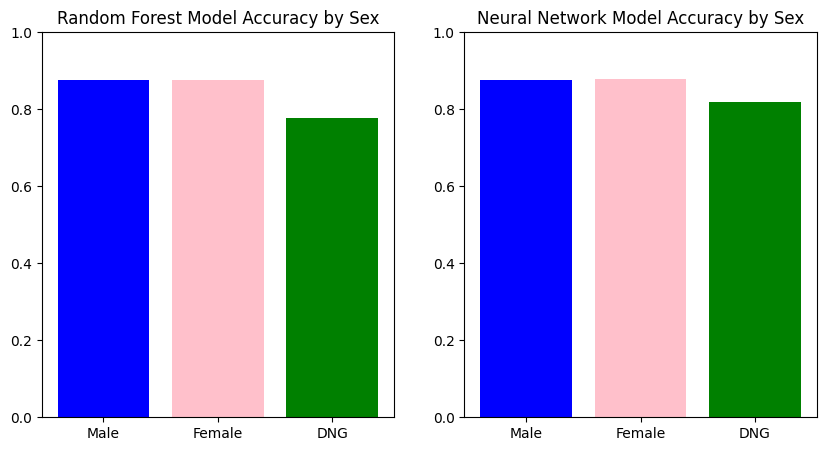

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

labels = ['Male', 'Female', 'DNG']
colors = ['blue', 'pink', 'green']

# Random Forest
rf_accuracies = [rf_accuracy_male.mean(), rf_accuracy_female.mean(), rf_accuracy_dng.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Sex')
axs[0].set_ylim(0, 1)

# Neural Net
nn_accuracies = [nn_accuracy_male.mean(), nn_accuracy_female.mean(), nn_accuracy_dng.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Sex')
axs[1].set_ylim(0, 1)

# Display the plots
plt.show()

### Race - Random Forest

In [74]:

rf_accuracy_white = rf_test_df[rf_test_df['raceEthnicity_Non-Hispanic (NH), White'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Non-Hispanic (NH), White'] == True]['Predicted']
rf_accuracy_black = rf_test_df[rf_test_df['raceEthnicity_NH, Black'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Black'] == True]['Predicted']
rf_accuracy_hispanic = rf_test_df[rf_test_df['raceEthnicity_Hispanic (Any Race)'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Hispanic (Any Race)'] == True]['Predicted']
rf_accuracy_unknown = rf_test_df[rf_test_df['raceEthnicity_Race/Ethnicity Unknown'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Race/Ethnicity Unknown'] == True]['Predicted']
rf_accuracy_native = rf_test_df[rf_test_df['raceEthnicity_NH, Am Ind AK Native'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Am Ind AK Native'] == True]['Predicted']
rf_accuracy_more = rf_test_df[rf_test_df['raceEthnicity_NH, More than One Race'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, More than One Race'] == True]['Predicted']
rf_accuracy_asian = rf_test_df[rf_test_df['raceEthnicity_NH, Asian'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Asian'] == True]['Predicted']
rf_accuracy_pacific = rf_test_df[rf_test_df['raceEthnicity_NH, Hawaiian / Other Pac Islander'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Hawaiian / Other Pac Islander'] == True]['Predicted']

print(f"Accuracy for Black: {rf_accuracy_black.mean()}")
print(f"Accuracy for White: {rf_accuracy_white.mean()}")
print(f"Accuracy for Hispanic: {rf_accuracy_hispanic.mean()}")
print(f"Accuracy for Unknown: {rf_accuracy_unknown.mean()}")
print(f"Accuracy for Native: {rf_accuracy_native.mean()}")
print(f"Accuracy for More: {rf_accuracy_more.mean()}")
print(f"Accuracy for Asian: {rf_accuracy_asian.mean()}")
print(f"Accuracy for Pacific: {rf_accuracy_pacific.mean()}")

Accuracy for Black: 0.8622763012772618
Accuracy for White: 0.8744012000193552
Accuracy for Hispanic: 0.8938647089669638
Accuracy for Unknown: 0.8632478632478633
Accuracy for Native: 0.8347597103357473
Accuracy for More: 0.8787849566055931
Accuracy for Asian: 0.9207792207792208
Accuracy for Pacific: 0.9026548672566371


### Race - Neural Network

In [75]:
nn_test_df['raceEthnicity'].value_counts()

raceEthnicity
Non-Hispanic (NH), White             311072
Hispanic (Any Race)                  142180
NH, Black                            140152
NH, More than One Race                51522
NH, Am Ind AK Native                  15080
Race/Ethnicity Unknown                11434
NH, Asian                              3936
NH, Hawaiian / Other Pac Islander      1877
Name: count, dtype: int64

In [76]:
# Calculate accuracy for each group
nn_accuracy_white = nn_test_df[nn_test_df['raceEthnicity'] == 'Non-Hispanic (NH), White']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Non-Hispanic (NH), White']['Predicted']
nn_accuracy_black = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Black']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Black']['Predicted']
nn_accuracy_hispanic = nn_test_df[nn_test_df['raceEthnicity'] == 'Hispanic (Any Race)']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Hispanic (Any Race)']['Predicted']
nn_accuracy_unknown = nn_test_df[nn_test_df['raceEthnicity'] == 'Race/Ethnicity Unknown']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Race/Ethnicity Unknown']['Predicted']
nn_accuracy_native = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Am Ind AK Native']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Am Ind AK Native']['Predicted']
nn_accuracy_more = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, More than One Race']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, More than One Race']['Predicted']
nn_accuracy_asian = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Asian']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Asian']['Predicted']
nn_accuracy_pacific = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Hawaiian / Other Pac Islander']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Hawaiian / Other Pac Islander']['Predicted']


print(f"Accuracy for Black: {nn_accuracy_black.mean()}")
print(f"Accuracy for White: {nn_accuracy_white.mean()}")
print(f"Accuracy for Hispanic: {nn_accuracy_hispanic.mean()}")
print(f"Accuracy for Unknown: {nn_accuracy_unknown.mean()}")
print(f"Accuracy for Native: {nn_accuracy_native.mean()}")
print(f"Accuracy for More: {nn_accuracy_more.mean()}")
print(f"Accuracy for Asian: {nn_accuracy_asian.mean()}")
print(f"Accuracy for Pacific: {nn_accuracy_pacific.mean()}")

Accuracy for Black: 0.8623423140590216
Accuracy for White: 0.8779092943112848
Accuracy for Hispanic: 0.8955619637079758
Accuracy for Unknown: 0.8715235263249956
Accuracy for Native: 0.8358090185676392
Accuracy for More: 0.8829626179107953
Accuracy for Asian: 0.9105691056910569
Accuracy for Pacific: 0.8939797549280767


## Plot Race Bias

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_32587/139782139.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45)
/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_32587/139782139.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45)


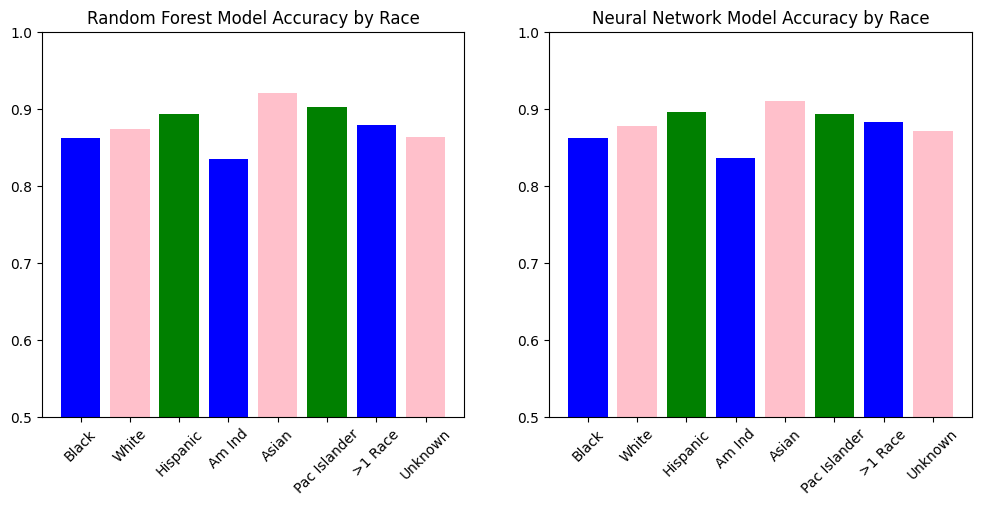

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

labels = ['Black', 'White', 'Hispanic', 'Am Ind', 'Asian', 'Pac Islander', '>1 Race', 'Unknown']
# colors = ['blue', 'pink', 'green']

# Random Forest
rf_accuracies = [rf_accuracy_black.mean(), rf_accuracy_white.mean(), rf_accuracy_hispanic.mean(), rf_accuracy_native.mean(), rf_accuracy_asian.mean(), rf_accuracy_pacific.mean(),  rf_accuracy_more.mean(), rf_accuracy_unknown.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Race')
axs[0].set_ylim(.5, 1)
axs[0].set_xticklabels(labels, rotation=45)

# Neural Net
nn_accuracies = [nn_accuracy_black.mean(), nn_accuracy_white.mean(), nn_accuracy_hispanic.mean(), nn_accuracy_native.mean(), nn_accuracy_asian.mean(), nn_accuracy_pacific.mean(), nn_accuracy_more.mean(), nn_accuracy_unknown.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Race')
axs[1].set_ylim(.5, 1)
axs[1].set_xticklabels(labels, rotation=45)

# Display the plots
plt.show()


### Dignosed Disability - Random Forest

In [78]:
rf_accuracy_yes = rf_test_df[rf_test_df['diagnosedDisability_Yes'] == 1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_Yes'] == 1]['Predicted']
rf_accuracy_no = rf_test_df[rf_test_df['diagnosedDisability_No'] == -1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_No'] == -1]['Predicted']
rf_accuracy_dng = rf_test_df[rf_test_df['diagnosedDisability_DNG'] == 1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_DNG'] == 1]['Predicted']
rf_accuracy_nyd = rf_test_df[rf_test_df['diagnosedDisability_Not yet determined'] == 1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_Not yet determined'] == 1]['Predicted']

print(f"Accuracy for No Disability: {rf_accuracy_no.mean()}")
print(f"Accuracy for Disability: {rf_accuracy_yes.mean()}")
print(f"Accuracy for DNG: {rf_accuracy_dng.mean()}")
print(f"Accuracy for Not Yet Determined: {rf_accuracy_nyd.mean()}")

Accuracy for No Disability: 0.8809798543459756
Accuracy for Disability: 0.9033101329934974
Accuracy for DNG: 0.8414848256834713
Accuracy for Not Yet Determined: 0.852202462380301


### Diagnosed Disability - Neural Network

In [79]:
nn_accuracy_yes = nn_test_df[nn_test_df['diagnosedDisability'] == 'Yes']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'Yes']['Predicted']
nn_accuracy_no = nn_test_df[nn_test_df['diagnosedDisability'] == 'No']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'No']['Predicted']
nn_accuracy_dng = nn_test_df[nn_test_df['diagnosedDisability'] == 'DNG']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'DNG']['Predicted']
nn_accuracy_nyd = nn_test_df[nn_test_df['diagnosedDisability'] == 'Not yet determined']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'Not yet determined']['Predicted']

print(f"Accuracy for No Disability: {nn_accuracy_no.mean()}")
print(f"Accuracy for Disability: {nn_accuracy_yes.mean()}")
print(f"Accuracy for DNG: {nn_accuracy_dng.mean()}")
print(f"Accuracy for Not Yet Determined: {nn_accuracy_nyd.mean()}")

Accuracy for No Disability: 0.8772871343313262
Accuracy for Disability: 0.9011124522885199
Accuracy for DNG: 0.8435150609907891
Accuracy for Not Yet Determined: 0.8498394179720784


## Plot Diagnosed Disability Bias

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_32587/2371518434.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45)
/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_32587/2371518434.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45)


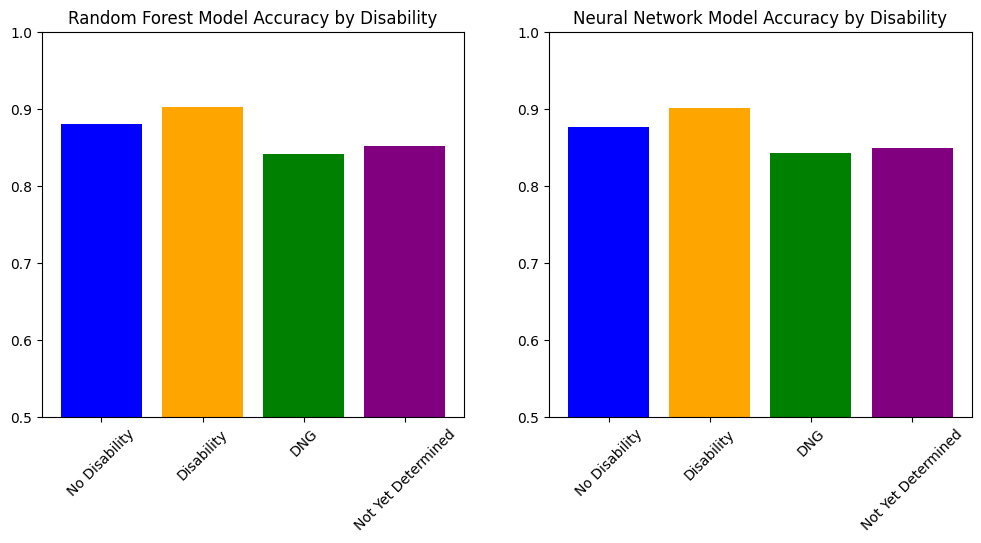

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

labels = ['No Disability', 'Disability', 'DNG', 'Not Yet Determined']
colors = ['blue', 'orange', 'green', 'purple']

# Random Forest
rf_accuracies = [rf_accuracy_no.mean(), rf_accuracy_yes.mean(), rf_accuracy_dng.mean(), rf_accuracy_nyd.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Disability')
axs[0].set_ylim(.5, 1)
axs[0].set_xticklabels(labels, rotation=45)

# Neural Net
nn_accuracies = [nn_accuracy_no.mean(), nn_accuracy_yes.mean(), nn_accuracy_dng.mean(), nn_accuracy_nyd.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Disability')
axs[1].set_ylim(.5, 1)
axs[1].set_xticklabels(labels, rotation=45)

# Display the plots
plt.show()


# Dive into the incorrect predictions

# To Do:
- Dive into the incorrect predictions
- Visualize incorrect predictions
- Group by binary Disability/No Disability payment/no payment, etc
- Make sure that df split is correct and in the right location
- check for re-entering the system

In [91]:
incorrect_df = nn_test_df[nn_test_df['Actual'] != nn_test_df['Predicted']].reset_index(drop=True)

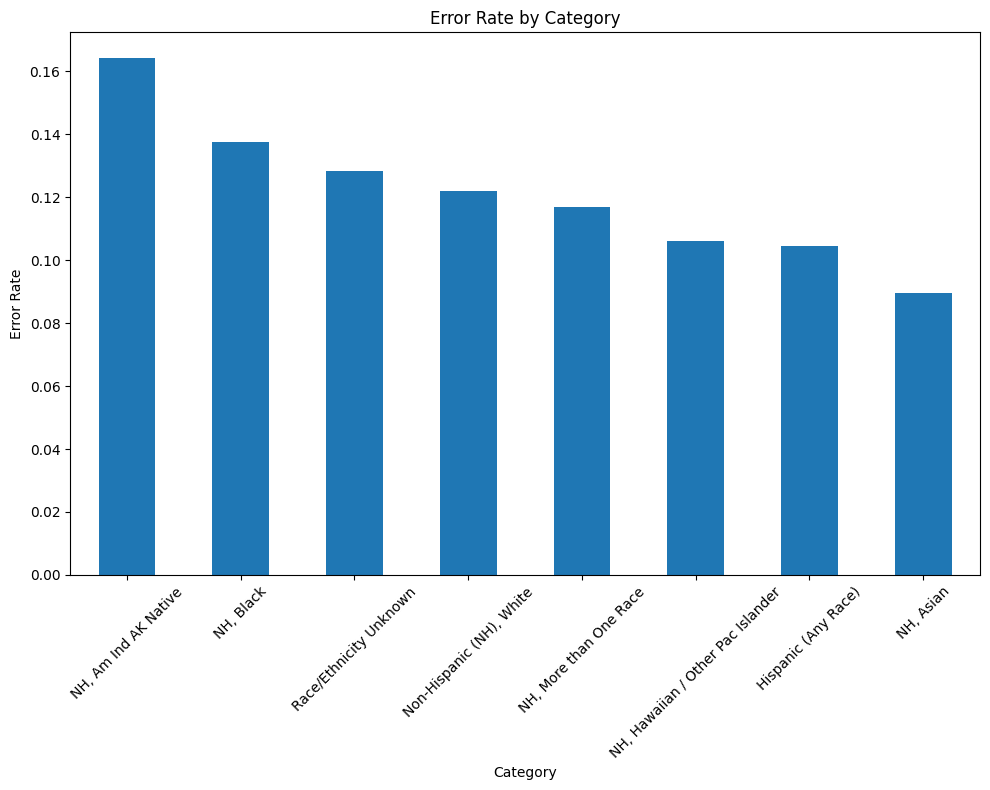

In [109]:
results_df = pd.DataFrame({
    'Actual': data_df['reunified'],
    'Predicted': predictions.flatten(),
    'Category': data_df['raceEthnicity']
})

# Flag incorrect predictions
results_df['Incorrect'] = (results_df['Actual'] != results_df['Predicted']).astype(int)

# Calculate error rate by category
error_rates = results_df.groupby('Category')['Incorrect'].mean()

# Sort the categories by error rate
error_rates = error_rates.sort_values(ascending=False)

# Plot the error rates
plt.figure(figsize=(10, 8))
error_rates.plot(kind='bar')
plt.title('Error Rate by Category')
plt.xlabel('Category')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)  # Rotate the category names to fit them nicely on the x-axis
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

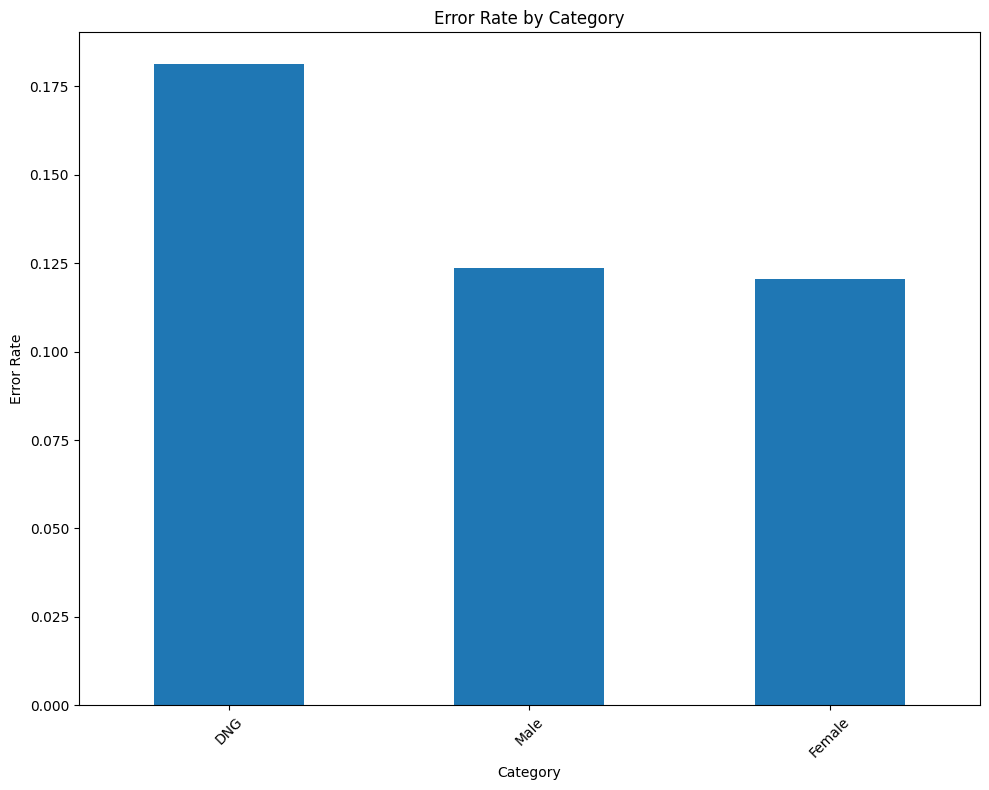

In [116]:
results_df = pd.DataFrame({
    'Actual': data_df['reunified'],
    'Predicted': predictions.flatten(),
    'Category': data_df['Sex']
})

# Flag incorrect predictions
results_df['Incorrect'] = (results_df['Actual'] != results_df['Predicted']).astype(int)

# Calculate error rate by category
error_rates = results_df.groupby('Category')['Incorrect'].mean()

# Sort the categories by error rate
error_rates = error_rates.sort_values(ascending=False)

# Plot the error rates
plt.figure(figsize=(10, 8))
error_rates.plot(kind='bar')
plt.title('Error Rate by Category')
plt.xlabel('Category')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)  # Rotate the category names to fit them nicely on the x-axis
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

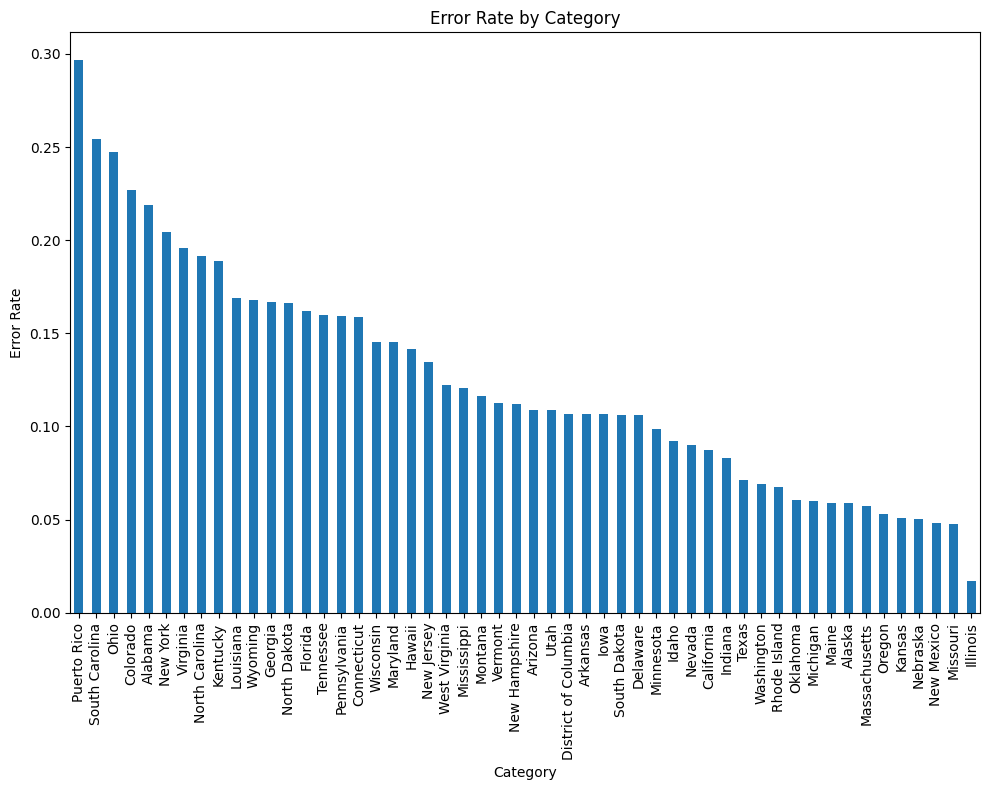

In [118]:
results_df = pd.DataFrame({
    'Actual': data_df['reunified'],
    'Predicted': predictions.flatten(),
    'Category': data_df['State']
})

# Flag incorrect predictions
results_df['Incorrect'] = (results_df['Actual'] != results_df['Predicted']).astype(int)

# Calculate error rate by category
error_rates = results_df.groupby('Category')['Incorrect'].mean()

# Sort the categories by error rate
error_rates = error_rates.sort_values(ascending=False)

# Plot the error rates
plt.figure(figsize=(10, 8))
error_rates.plot(kind='bar')
plt.title('Error Rate by Category')
plt.xlabel('Category')
plt.ylabel('Error Rate')
plt.xticks(rotation=90)  # Rotate the category names to fit them nicely on the x-axis
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

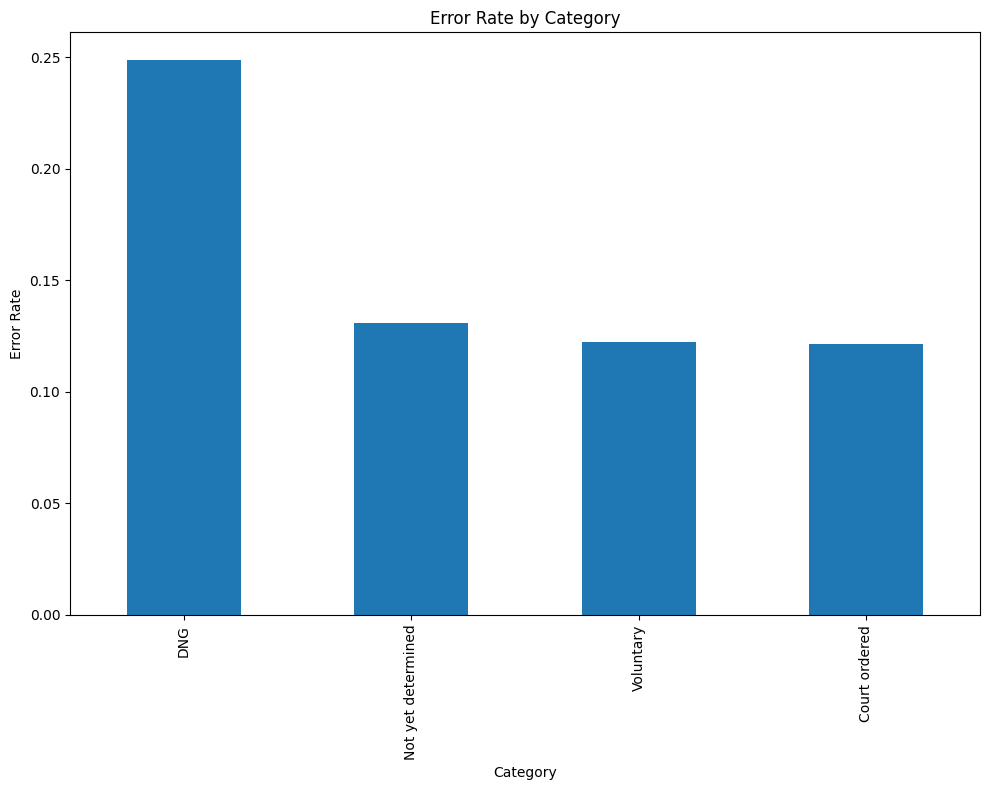

In [119]:
results_df = pd.DataFrame({
    'Actual': data_df['reunified'],
    'Predicted': predictions.flatten(),
    'Category': data_df['removalManner']
})

# Flag incorrect predictions
results_df['Incorrect'] = (results_df['Actual'] != results_df['Predicted']).astype(int)

# Calculate error rate by category
error_rates = results_df.groupby('Category')['Incorrect'].mean()

# Sort the categories by error rate
error_rates = error_rates.sort_values(ascending=False)

# Plot the error rates
plt.figure(figsize=(10, 8))
error_rates.plot(kind='bar')
plt.title('Error Rate by Category')
plt.xlabel('Category')
plt.ylabel('Error Rate')
plt.xticks(rotation=90)  # Rotate the category names to fit them nicely on the x-axis
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

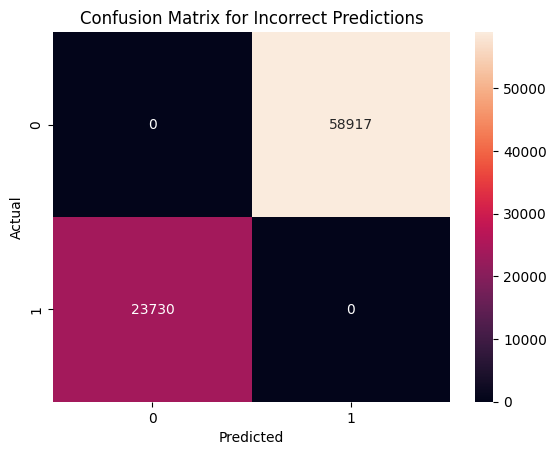

In [99]:
cm = confusion_matrix(incorrect_df['Actual'], incorrect_df['Predicted'])
# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Incorrect Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [93]:
incorrect_df

,Age,Sex,MR,TOTALREM,NUMPLEP,VISHEAR,PHYDIS,OTHERMED,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMntPay,SettingLOS,PreviousLOS,LifeLOS,AgeAtLatRem,IsTPR,Served,State,removalManner,currentPlacementSetting,caretakerFamilyStructure,fosterFamilyStructure,OutOfStatePlacement,everAdopted,diagnosedDisability,raceEthnicity,Actual,Predicted
0,18.0,Male,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,275.0,1077.0,0.0,0.0,14.0,0.0,1.0,West Virginia,Court ordered,"Foster home, non-relative",Single female,Married couple,No,"No, has never been legally adopted",Yes,"NH, More than One Race",1,0
1,12.0,Male,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,1.0,Mississippi,Court ordered,"Foster home, non-relative",Married couple,DNG,No,"No, has never been legally adopted",No,"Non-Hispanic (NH), White",0,1
2,4.0,Female,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,826.0,200.0,419.0,619.0,4.0,0.0,1.0,California,Court ordered,"Foster home, relative",Single female,Married couple,No,"No, has never been legally adopted",Yes,"Non-Hispanic (NH), White",0,1
3,12.0,Male,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,458.0,0.0,458.0,10.0,0.0,1.0,Indiana,Court ordered,"Foster home, relative",Single male,Single female,No,"No, has never been legally adopted",Not yet determined,"NH, Black",1,0
4,9.0,Male,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,216.0,0.0,216.0,9.0,0.0,1.0,Ohio,Court ordered,"Foster home, relative",Single female,Single female,No,"No, has never been legally adopted",No,Hispanic (Any Race),0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82642,13.0,Male,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3223.0,442.0,1181.0,2020.0,11.0,0.0,1.0,New York,Court ordered,"Foster home, relative",Single female,Single female,No,"No, has never been legally adopted",Yes,"NH, Black",0,1
82643,13.0,Female,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2375.0,43.0,0.0,43.0,12.0,0.0,1.0,California,Court ordered,"Foster home, non-relative",Single female,Married couple,No,"No, has never been legally adopted",No,"Non-Hispanic (NH), White",0,1
82644,2.0,Male,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,421.0,428.0,0.0,514.0,0.0,0.0,1.0,Louisiana,Court ordered,"Foster home, relative",Married couple,Married couple,No,"No, has never been legally adopted",No,"Non-Hispanic (NH), White",1,0
82645,1.0,Female,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1277.0,115.0,0.0,178.0,1.0,0.0,1.0,Indiana,Not yet determined,"Foster home, relative",Unmarried couple,Unmarried couple,No,"No, has never been legally adopted",Not yet determined,"Non-Hispanic (NH), White",0,1


In [82]:
incorrect_df

,MR,VISHEAR,PHYDIS,EMOTDIST,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMNTPAY,SETTINGLOS,PREVIOUSLOS,LIFELOS,AGEATLATREM,AGEATEND,INATSTART,SERVED,ISWAITING,ISTPR,AGEDOUT,State,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caretakerFamilyStructure,fosterFamilyStructure,raceEthnicity,everAdopted,diagnosedDisability,reunified,Actual,Predicted
0,0.0,0.0,0.0,NaN,0.0,4.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Virginia,Male,NaN,Court ordered,"Foster home, non-relative",No,Single female,Married couple,"NH, More than One Race","No, has never been legally adopted",Yes,NaN,1,0
1,0.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mississippi,Male,NaN,Court ordered,"Foster home, non-relative",No,Married couple,DNG,"Non-Hispanic (NH), White","No, has never been legally adopted",No,NaN,0,1
2,0.0,0.0,0.0,NaN,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California,Female,NaN,Court ordered,"Foster home, relative",No,Single female,Married couple,"Non-Hispanic (NH), White","No, has never been legally adopted",Yes,NaN,0,1
3,0.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indiana,Male,NaN,Court ordered,"Foster home, relative",No,Single male,Single female,"NH, Black","No, has never been legally adopted",Not yet determined,NaN,1,0
4,0.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ohio,Male,NaN,Court ordered,"Foster home, relative",No,Single female,Single female,Hispanic (Any Race),"No, has never been legally adopted",No,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82642,0.0,0.0,0.0,NaN,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New York,Male,NaN,Court ordered,"Foster home, relative",No,Single female,Single female,"NH, Black","No, has never been legally adopted",Yes,NaN,0,1
82643,0.0,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California,Female,NaN,Court ordered,"Foster home, non-relative",No,Single female,Married couple,"Non-Hispanic (NH), White","No, has never been legally adopted",No,NaN,0,1
82644,0.0,0.0,0.0,NaN,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Louisiana,Male,NaN,Court ordered,"Foster home, relative",No,Married couple,Married couple,"Non-Hispanic (NH), White","No, has never been legally adopted",No,NaN,1,0
82645,0.0,0.0,0.0,NaN,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indiana,Female,NaN,Not yet determined,"Foster home, relative",No,Unmarried couple,Unmarried couple,"Non-Hispanic (NH), White","No, has never been legally adopted",Not yet determined,NaN,0,1
